In [1]:
# Core Libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Preprocessing & Feature Engineering
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

# Modeling & Evaluation
import lightgbm as lgb
import optuna
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Notebook settings
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
plt.style.use('seaborn-v0_8-deep')

print("Libraries imported successfully.")

Libraries imported successfully.


In [2]:
# Load the datasets
try:
    train_df = pd.read_csv("train.csv")
    test_df = pd.read_csv("test.csv")  # Corrected filename
    sample_submission_df = pd.read_csv("sample_submission.csv")
except FileNotFoundError as e:
    print(f"File not found: {e}. Please ensure all CSV files are in the correct directory.")
    # Fallback for environments where files are not present
    train_df = pd.DataFrame()
    test_df = pd.DataFrame()
    sample_submission_df = pd.DataFrame()

if not train_df.empty:
    print("Training Data Shape:", train_df.shape)
    print("Testing Data Shape:", test_df.shape)
    
    print("\nFirst 5 rows of the training data:")
    display(train_df.head())

Training Data Shape: (18524, 9)
Testing Data Shape: (6175, 8)

First 5 rows of the training data:


,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


print("Training Data Info:")
train_df.info()

# Visualize missing values
msno.matrix(train_df, figsize=(12, 5), fontsize=10)
plt.title('Missing Value Matrix (Train Data)', fontsize=16)
plt.show()

msno.matrix(test_df, figsize=(12, 5), fontsize=10)
plt.title('Missing Value Matrix (Test Data)', fontsize=16)
plt.show()

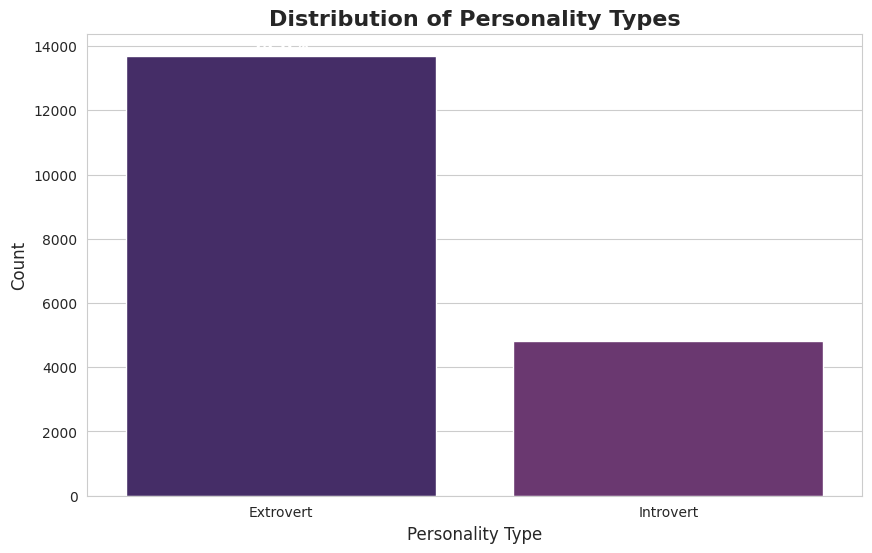

In [4]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='Personality', data=train_df, palette=['#432371', '#712F79'])
plt.title('Distribution of Personality Types', fontsize=16, fontweight='bold')
plt.xlabel('Personality Type', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Add percentages on top of the bars
total = len(train_df)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom', fontsize=12, color='white', fontweight='bold')

plt.show()

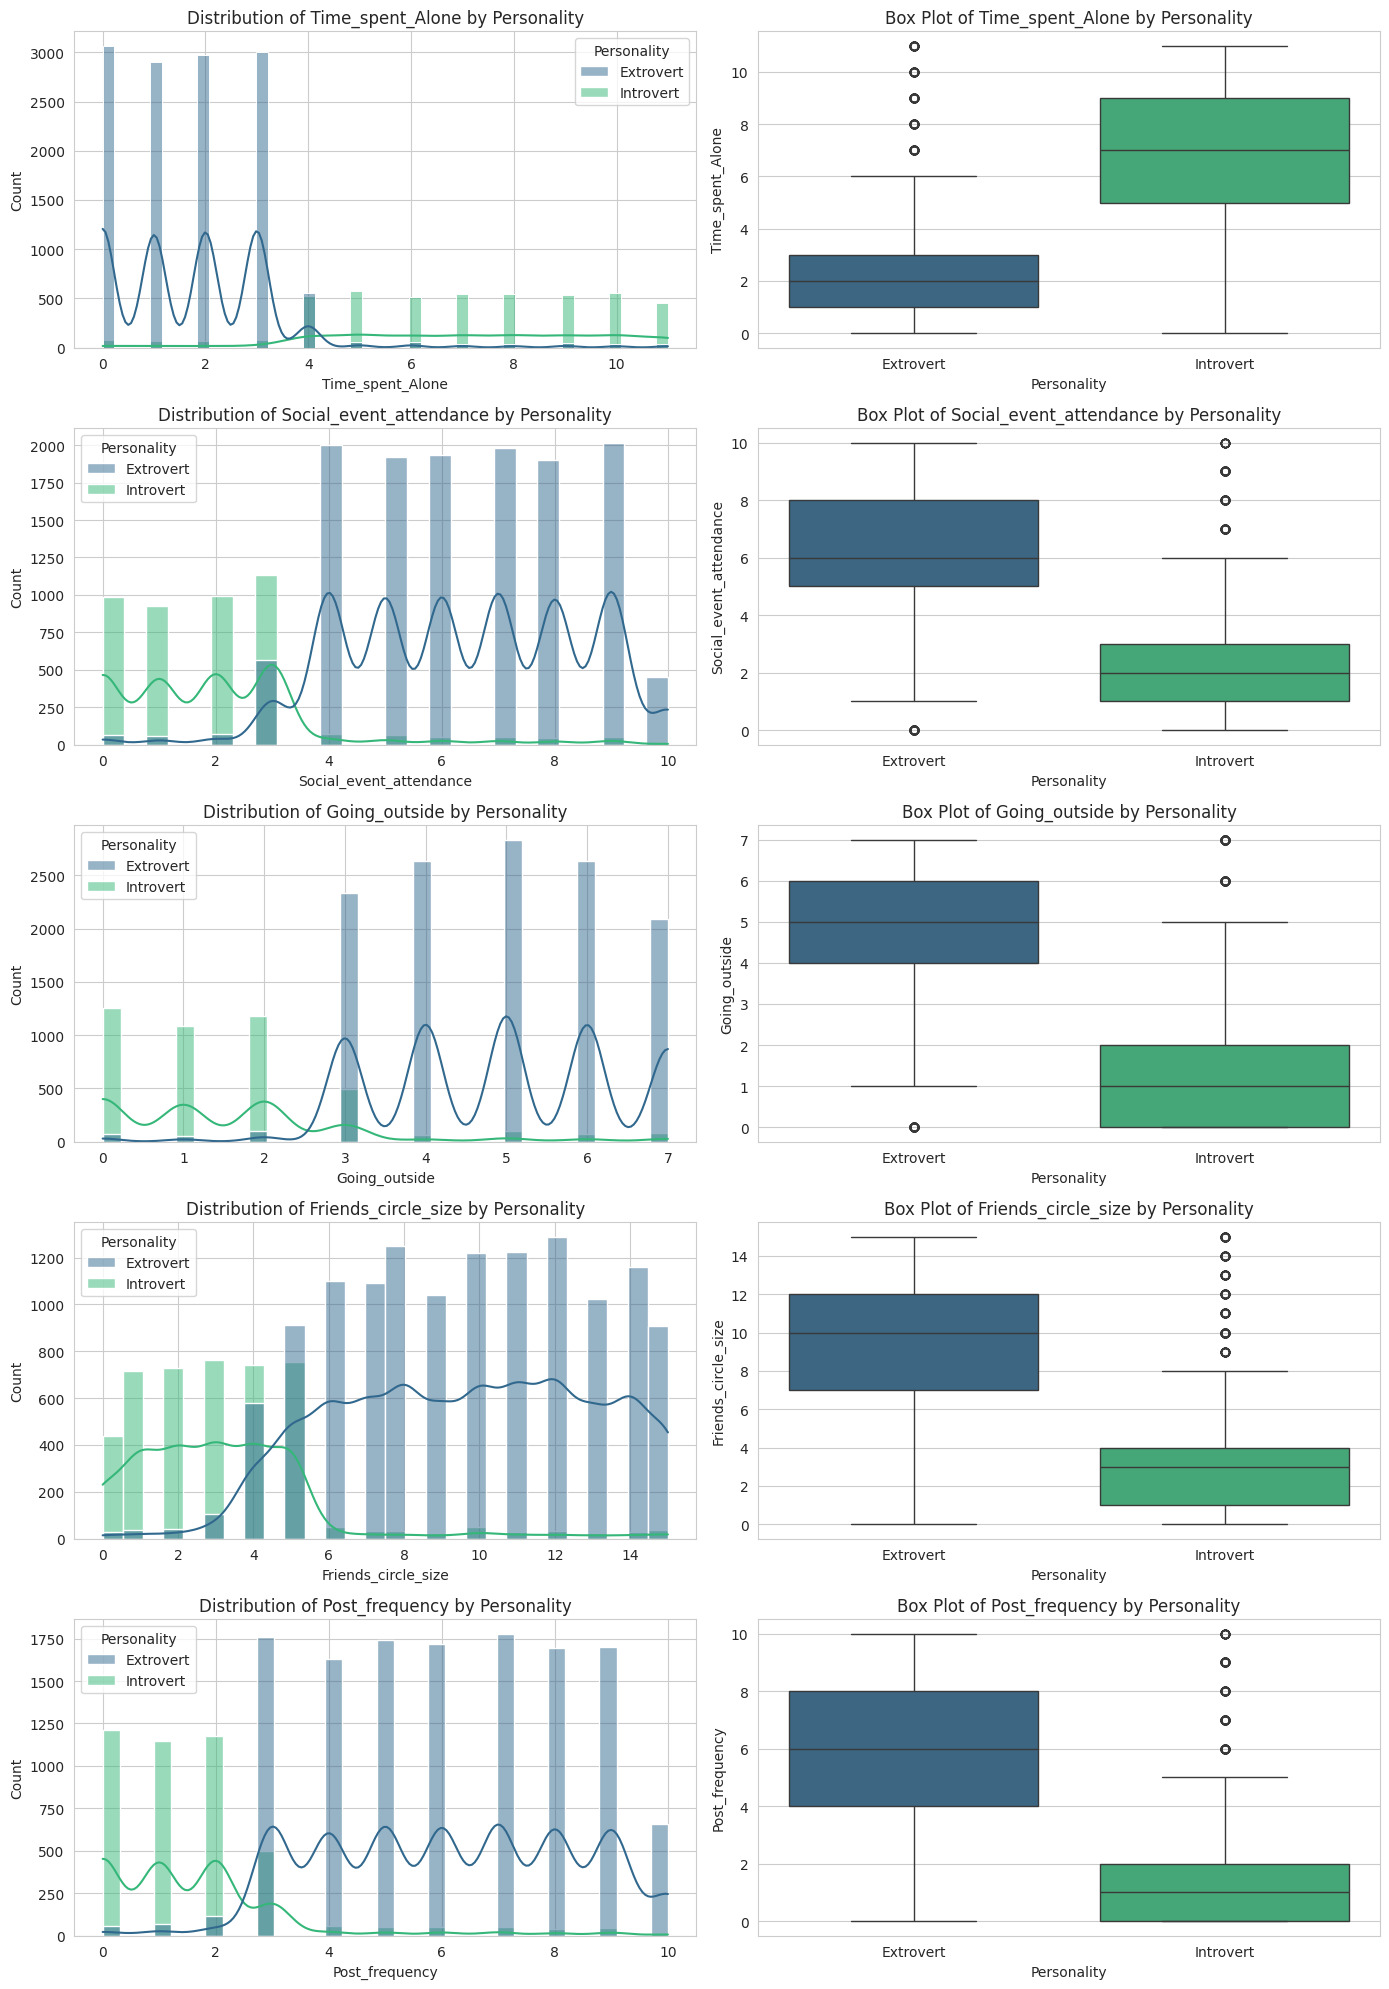

In [5]:
# Numerical features
numerical_features = train_df.select_dtypes(include=np.number).columns.drop(['id'])
fig, axes = plt.subplots(len(numerical_features), 2, figsize=(14, 20))

for i, col in enumerate(numerical_features):
    sns.histplot(data=train_df, x=col, hue='Personality', kde=True, ax=axes[i, 0], palette='viridis')
    axes[i, 0].set_title(f'Distribution of {col} by Personality')
    
    sns.boxplot(data=train_df, x='Personality', y=col, ax=axes[i, 1], palette='viridis')
    axes[i, 1].set_title(f'Box Plot of {col} by Personality')

plt.tight_layout()
plt.show()

# Categorical features
categorical_features = ['Stage_fear', 'Drained_after_socializing']
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for i, col in enumerate(categorical_features):
    sns.countplot(data=train_df, x=col, hue='Personality', ax=axes[i], palette='magma')
    axes[i].set_title(f'{col} vs. Personality', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [7]:
# Combine for consistent processing
combined_df = pd.concat([train_df.drop('Personality', axis=1), test_df], ignore_index=True)

# Binary Feature Encoding
binary_cols = ['Stage_fear', 'Drained_after_socializing']
for col in binary_cols:
    combined_df[col] = combined_df[col].map({'Yes': 1, 'No': 0})

In [8]:
print("Engineering new features...")

# Interaction and Ratio Features
# Use small epsilon to avoid division by zero
epsilon = 1e-6
combined_df['Social_Energy_Score'] = (combined_df['Social_event_attendance'] + combined_df['Going_outside']) / (combined_df['Time_spent_Alone'] + epsilon)
combined_df['Online_Offline_Ratio'] = combined_df['Post_frequency'] / (combined_df['Social_event_attendance'] + epsilon)
combined_df['Friends_to_Alone_Ratio'] = combined_df['Friends_circle_size'] / (combined_df['Time_spent_Alone'] + epsilon)

# Polynomial features for strong predictors
for col in ['Time_spent_Alone', 'Social_event_attendance']:
    combined_df[f'{col}_sq'] = combined_df[col]**2

# Create flags for missing values before imputation
for col in combined_df.columns:
    if combined_df[col].isnull().any():
        combined_df[f'{col}_missing_flag'] = combined_df[col].isnull().astype(int)

print("Feature engineering complete. New features created.")
display(combined_df.head())

Engineering new features...
Feature engineering complete. New features created.


,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Social_Energy_Score,Online_Offline_Ratio,Friends_to_Alone_Ratio,Time_spent_Alone_sq,Social_event_attendance_sq,Time_spent_Alone_missing_flag,Stage_fear_missing_flag,Social_event_attendance_missing_flag,Going_outside_missing_flag,Drained_after_socializing_missing_flag,Friends_circle_size_missing_flag,Post_frequency_missing_flag,Social_Energy_Score_missing_flag,Online_Offline_Ratio_missing_flag,Friends_to_Alone_Ratio_missing_flag,Time_spent_Alone_sq_missing_flag,Social_event_attendance_sq_missing_flag
0,0,0.0,0.0,6.0,4.0,0.0,15.0,5.0,1.000000e+07,0.833333,1.500000e+07,0.0,36.0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1.0,0.0,7.0,3.0,0.0,10.0,8.0,9.999990e+00,1.142857,9.999990e+00,1.0,49.0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,6.0,1.0,1.0,0.0,NaN,3.0,0.0,1.666666e-01,0.000000,4.999999e-01,36.0,1.0,0,0,0,0,1,0,0,0,0,0,0,0
3,3,3.0,0.0,7.0,3.0,0.0,11.0,5.0,3.333332e+00,0.714286,3.666665e+00,9.0,49.0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,1.0,0.0,4.0,4.0,0.0,13.0,NaN,7.999992e+00,NaN,1.299999e+01,1.0,16.0,0,0,0,0,0,0,1,0,1,0,0,0


In [11]:
if not combined_df.empty:
    # KNN Imputer
    print("Applying KNN Imputer...")
    imputer = KNNImputer(n_neighbors=7) # Using 7 neighbors can capture more complex patterns
    imputed_data = imputer.fit_transform(combined_df)
    combined_df_imputed = pd.DataFrame(imputed_data, columns=combined_df.columns)

    # Scaling
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(combined_df_imputed)
    combined_df_processed = pd.DataFrame(scaled_data, columns=combined_df_imputed.columns)
    
    print("Imputation and scaling complete.")

Applying KNN Imputer...
Imputation and scaling complete.


In [13]:
if not combined_df.empty:
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    X_processed = combined_df_processed.iloc[:len(train_df)]
    X_test_processed = combined_df_processed.iloc[len(train_df):]

    print("Final Processed Training Data Shape:", X_processed.shape)
    print("Final Processed Test Data Shape:", X_test_processed.shape)

ValueError: y should be a 1d array, got an array of shape () instead.